# Prediction of tumor immune cell infiltration based on extracellular matrix organization

In [2]:
%matplotlib inline
# Import modules
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score#, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
import graphviz

# Local modules
import auxiliary
import plots
import ExtractMap

## Lecture du jeu de données

Les jeux de données d'intérêts, ont été composés à l'aide de différents descripteurs extraits par une convolution (une fenêtre de **n*****n**pixels que l'on fait glisser sur notre image) réalisée sur des images de coupe histologique de cellules tumorales. C'est à dire qu'à différentes position d'une image on extrait des descripteurs afin de constituer notre jeu de données.  

**n** a été réalisée pour des fenêtres de tailles 20, 60, 100, 140 pixels.  

Les expériences sur les cellules tumorales ont été réalisées sous différentes conditions, avec la présence des macrophages (WT) et en déplétant les macrophages (KI ou CD64-hDTR).

In [3]:
# Path to dataframes
filepath_wt = "../data/WTconcatenate.csv.gz"
filepath_ki = "../data/KIconcatenate.csv.gz"

# Read dataframes
df_wt = auxiliary.read_dataframe(filepath_wt, low_memory=False)
df_ki = auxiliary.read_dataframe(filepath_ki, low_memory=False)

WT_lab = "WT"
KI_lab = "KI"
df_ki["Condition"] = KI_lab

### Information sur les descripteurs du jeu de données

| Variable | type | Description |  
| --- | --- | --- |  
| **Condition** | (str) | Cette variable informe sur le phénotype Wild Type (WT) ou déplété en macrophage (KI) de l'environnement micro-tumorale observé. |
| **FileName** | (str) | Nom du fichier auquel sur lequel sont réalisés les analyses. |
| **X** | (int) | Position en X de la fenêtre. <br> Entier naturel strictement positif. |
| **Y** | (int) | Position en Y de la fenêtre. <br> Entier naturel strictement positif. |
| **Coherency** | (float) | Désordre des fibres contenu au sein de la fenêtre. <br> C'est une variable quantitative qui varie entre 0 (total désordre) et 1 (ordre total). |
| **Energy** | (float) | **A VERIFIER** <br> Cette variable quantitative informe sur le contraste présent au sein de la fenêtre. <br> Cette variable varie entre 0 (aucun contraste) et 1 (fort contraste)|
| **MeanInt** | (float) | Intensité moyenne au sein de la fenêtre |
| **VarInt** | (float) | Variance de l'intensité au sein de la fenêtre. |
| **Density** | (float) | Variable quantitative qui permet de quantifier les fibres au sein de la fenêtre. <br>Elle varie entre 0 lorsqu'il n'y a aucune fibre, et 1 lorsque la fenêtre est entièrement composée de fibres. |
| **VarDensity** | (float) | Variance calculée sur la densité. |
| **OrientationRef** | (float) | Orientation des fibres par rapport à une rotation de référence sur une fenêtre plus large. <br> Varie entre $-\pi$ et $\pi$. |
| **Dist** | (float) | Distance à l'extremité de la paroi cellulaire |
| **Angle** | (float) | |  
| **Mask** | (bool) | Variable catégorielle indiquant si l'observation se situe au sein de la tumeur (Mask=1) ou en dehors de la tumeur (Mask=0). |
| **Type** | (str) | Variable catégorielle informant sur le type cellulaire auquel on s'intéresse, CD3 pour les lymphocytes T |
| **Cells** | (int)/(float)| Entier positif correspondant au nombre de cellule immunitaire (en fonction de la variable Type) observé au sein de la fenêtre. |
| **MinDist** | (float) | Distance à la plus proche cellule voisine. |
| **MedDist** | (float) | Distance median par rapport aux valeurs de distances des cellules immunitaires voisines les plus proches. |
| **CellArea** | (float) | Aire de la cellule immunitaire. |
| **CellEcc** | (float) | Excentricité de la cellule immunitaire. Cette variable permet de décrire la forme de la cellule (allongé/arrondie). |
| **Cells100um** | (float) | Nombre de cellules immunitaire à 100um. |
| **MinDist100um** | (float) | **A VERIFIER (différence avec MinDist)** |
| **MedDist100um** | (float) | Distance mediam par rapport au distances des cellules immunitaires voisines à 100um.|
| **CellArea100um** | (float) | |
| **CellEcc100um** | (float) | |
| **Frac** | (float) | La fractalité est une mesure de la répétition des patterns|

### Conversion du type des colonnes

On attribut à chaque colonne un type spécifique afin de spécifier l'espace mémoire que celles-ci peuvent prendre. Les entier, sont convertis en type int32 (ou uint32 pour les variables strictements positives).  

Les variables quantitatives à valeurs flottantes sont converties en float64.  
Sont convertis en np.object, les variables représentant des chaînes de caractères (phenotype WT/KI, nom du fichier, type cellulaire Ly6/CD3).  

Ces conversions sont pratiques afin de clarifier les types associés aux variables, et pour la gestion de l'espace mémoire que l'on assigne à celles-ci.

In [4]:
# Assigned columns to types
str_columns = ["Condition", "FileName", "Type"]
integer_columns = ["Mask"]  # "Cells", converted to float due to NaN exception
nonsigned_columns = ["X", "Y"]
float_20_columns = ["Angle20", "Coherency20", "Energy20", "MeanInt20", "VarInt20", "Density20", "VarDensity20", "OrientationRef20"]
float_60_columns = ["Angle60", "Coherency60", "Energy60", "MeanInt60", "VarInt60", "Density60", "VarDensity60", "OrientationRef60"]
float_100_columns = ["Angle100", "Coherency100", "Energy100", "MeanInt100", "VarInt100", "Density100", "VarDensity100", "OrientationRef100"]
float_140_columns = ["Angle140", "Coherency140", "Energy140", "MeanInt140", "VarInt140", "Density140", "VarDensity140", "OrientationRef140"]
distances_columns = ["Dist", "MinDist", "MedDist"]
shape_columns = ["Frac", "CellArea", "CellEcc"]
cell_100um_columns = ["Cells100um", "MinDist100um", "MedDist100um", "CellArea100um", "CellEcc100um"]
#
x_columns = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns,
    *distances_columns, *shape_columns, *cell_100um_columns
]
y_columns = ["Cells"]
float_columns = [
    *x_columns, *y_columns
]

# Associate a type to each columns
data_type = {
    **dict.fromkeys(str_columns, object),
    **dict.fromkeys(nonsigned_columns, np.uint32),
    **dict.fromkeys(float_columns, np.float64),
    **dict.fromkeys(integer_columns, np.int32)
}

df_wt = df_wt.astype(data_type)
df_ki = df_ki.astype(data_type)

# Fusion des deux jeu de données
df_all = pd.concat([df_wt, df_ki])

In [5]:
print("\nJeu de données complet")
print(f"Nombre de lignes au sein du jeu de données total: {df_all.shape[0]}")
print(f"Nombre de colonnes au sein du jeu de données total: {df_all.shape[1]}")
print()
df_all.head()


Jeu de données complet
Nombre de lignes au sein du jeu de données total: 6697691
Nombre de colonnes au sein du jeu de données total: 50



,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
0,WT,./12a_FWT155_Ly6G_SHG.tif,23,29,0.160,0.000084,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,WT,./12a_FWT155_Ly6G_SHG.tif,63,29,0.167,0.000103,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,WT,./12a_FWT155_Ly6G_SHG.tif,103,29,0.176,0.000140,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,WT,./12a_FWT155_Ly6G_SHG.tif,143,29,0.185,0.000197,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,WT,./12a_FWT155_Ly6G_SHG.tif,183,29,0.191,0.000275,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
# Descriptif sur les variables quantitatives
df_all_desc = df_all.describe()
df_all_desc

,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,Coherency140,Energy140,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
count,6.697691e+06,6.697691e+06,6.697691e+06,6.697691e+06,6.662657e+06,6.662657e+06,6.662657e+06,6.662657e+06,6.697691e+06,6.697691e+06,...,3.226775e+06,3.226775e+06,3.226775e+06,3.226775e+06,6.697691e+06,3.226775e+06,3.226775e+06,3.226775e+06,3.226775e+06,1.616940e+06
mean,7.168084e+03,7.305759e+03,1.524157e-01,8.355423e-02,5.921653e+00,7.108386e+01,1.688810e-01,3.661304e-02,1.553567e-01,1.032972e-01,...,2.811799e+00,5.926502e+00,6.276004e+00,1.463598e-01,3.535534e+00,1.859412e+00,3.888546e+00,4.992713e+00,1.161127e-01,1.825627e+00
std,4.662676e+03,4.679211e+03,1.254165e-01,1.410929e-01,1.541357e+01,2.937218e+02,3.220997e-01,7.174971e-02,1.209173e-01,1.606857e-01,...,8.781794e+00,1.920741e+01,1.779285e+01,3.911100e-01,9.522765e+00,3.548346e+00,8.903150e+00,9.948160e+00,2.209289e-01,2.355935e-01
min,2.000000e+01,2.000000e+01,1.414000e-28,2.961000e-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.076000e-30,5.413000e-34,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.757961e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.356107e-02
25%,3.437000e+03,3.464000e+03,6.200000e-02,9.953500e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.900000e-02,3.000000e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.734743e+00
50%,6.702000e+03,6.794000e+03,1.260000e-01,2.500000e-02,8.000000e-02,4.430000e-01,0.000000e+00,0.000000e+00,1.310000e-01,3.500000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.932144e+00
75%,1.015800e+04,1.050100e+04,2.130000e-01,9.600000e-02,3.966000e+00,1.816100e+01,1.180000e-01,2.700000e-02,2.140000e-01,1.260000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.210000e+00,2.888323e+00,6.228653e+00,5.906250e+00,1.579000e-01,1.995705e+00
max,2.934600e+04,2.127100e+04,9.260000e-01,9.990000e-01,2.545490e+02,1.375575e+04,1.000000e+00,2.500000e-01,9.190000e-01,9.990000e-01,...,7.919362e+02,1.987163e+03,5.697500e+02,6.171300e+00,1.137400e+02,4.438150e+01,8.259579e+02,3.065000e+02,3.749700e+00,2.000000e+00


## Lymphocytes T

Dans un premier temps, on s'intéresse seulement au lymphocytes T afin d'étudier la corrélation des différents descripteurs (forme de la matrice, distribution) avec le nombre de lymphocyte T.

In [7]:
# Keep only T cells in tumor environment
df_cd3_unmask = df_all[(df_all["Type"] == "CD3")]  # only T Cells
df_cd3_tumor = df_cd3_unmask[df_cd3_unmask["Mask"] == 1]  # T Cells, in tumor

# Number of observations per file
dt_cd3_tumor_perfile = df_cd3_tumor[["FileName", "Condition"]]\
    .groupby(["FileName"]).value_counts().to_frame()\
    .reset_index(level=1).sort_values(by="Condition", ascending=False)

dt_cd3_tumor_perfile["Name"] = [filename[2:filename.find(".tif")] for filename in dt_cd3_tumor_perfile.index]  # Add Name column
dt_cd3_tumor_perfile = dt_cd3_tumor_perfile.rename(columns={"count": "Nobs"})  # Rename count to Nobs
dt_cd3_tumor_perfile = dt_cd3_tumor_perfile.join(df_cd3_tumor[["FileName", "Cells"]].groupby(["FileName"]).sum())  # Add Cells count per file
dt_cd3_tumor_perfile = dt_cd3_tumor_perfile.reindex(columns=["Name", "Condition", "Nobs", "Cells"])  # Reorder columns
dt_cd3_tumor_perfile["DObs"] = dt_cd3_tumor_perfile["Nobs"] - dt_cd3_tumor_perfile["Cells"]  # Observations - Number of T Cells
dt_cd3_tumor_perfile["CellsPercent"] = (dt_cd3_tumor_perfile["Cells"] / dt_cd3_tumor_perfile["Nobs"])  # Proportion of T Cells
dt_cd3_tumor_perfile  # Nombre de données par fichier

,Name,Condition,Nobs,Cells,DObs,CellsPercent
FileName,,,,,,
./MAX_12b_187_CD3eFITC.tif_SHG.tif,MAX_12b_187_CD3eFITC,WT,71965,21448.0,50517.0,0.298034
./FWT_507_down_CD3FITC.tif_max.tif_SHG.tif,FWT_507_down_CD3FITC,WT,38647,8383.0,30264.0,0.216912
./MAX_12b_189_CD3eFITC.tif_SHG.tif,MAX_12b_189_CD3eFITC,WT,75969,17468.0,58501.0,0.229936
./MAX_12b_184_CD3eFITC.tif_SHG.tif,MAX_12b_184_CD3eFITC,WT,62492,16580.0,45912.0,0.265314
./MAX_12b_FWT331_CD3_SHG.tif,MAX_12b_FWT331_CD3_SHG,WT,82718,7657.0,75061.0,0.092568
./MAX_12b_FWT_333_CD3_SHG.tif,MAX_12b_FWT_333_CD3_SHG,WT,34373,5707.0,28666.0,0.166031
./FWT_928_right_CD3FITC.tif_max.tif_SHG.tif,FWT_928_right_CD3FITC,WT,50588,4934.0,45654.0,0.097533
./FWT_861_big_CD3FITC.tif_max.tif_SHG.tif,FWT_861_big_CD3FITC,WT,56876,12379.0,44497.0,0.217649
./FWT_511_CD3FITC_F480_AF647_Phal546.tif_max.tif_SHG.tif,FWT_511_CD3FITC_F480_AF647_Phal546,WT,34524,9538.0,24986.0,0.276272


In [8]:
table_byfile_condition = dt_cd3_tumor_perfile["Condition"].value_counts()

# Print
print()
print("Lymphocytes T")
print(f"Nombre de lignes au sein du jeu de données : {df_cd3_tumor.shape[0]}")
print(f"Nombre de colonnes au sein du jeu de données : {df_cd3_tumor.shape[1]}")
#
print()
print(f"Nombre d'images uniques : {dt_cd3_tumor_perfile.shape[0]}")
print(
    f"Nombre de tissus WT : {table_byfile_condition[WT_lab]}\n"
    f"Nombre de tissus KI : {table_byfile_condition[KI_lab]}"
)
# 
print()
print(f"Nombre d'observations en dehors de la tumeur (Mask=0): {((df_all['Type'] == 'CD3') & (df_all['Mask'] == 0)).sum()}")
print(f"Nombre d'observations au sein de la tumeur (Mask=1): {dt_cd3_tumor_perfile['Nobs'].sum()}")
#
print()
print(f"Nombre de positions avec fibres (Density20>0) = {sum(df_cd3_tumor['Density20'] > 0)}")
print(f"Nombre de positions sans fibres (Density20<=0) = {sum(df_cd3_tumor['Density20'] <= 0)}")
#
print()
print(f"Colonnes du jeu de données :")
_ = [print(f"{col:<18s}{'':3s}", end='') if (idx+1)%6 != 0 else print(col) 
     for idx, col in enumerate(df_cd3_tumor.columns.values)]



Lymphocytes T
Nombre de lignes au sein du jeu de données : 1867864
Nombre de colonnes au sein du jeu de données : 50

Nombre d'images uniques : 34
Nombre de tissus WT : 14
Nombre de tissus KI : 20

Nombre d'observations en dehors de la tumeur (Mask=0): 2028501
Nombre d'observations au sein de la tumeur (Mask=1): 1867864

Nombre de positions avec fibres (Density20>0) = 686933
Nombre de positions sans fibres (Density20<=0) = 1180931

Colonnes du jeu de données :
Condition            FileName             X                    Y                    Coherency100         Energy100
MeanInt100           VarInt100            Density100           VarDensity100        Coherency140         Energy140
MeanInt140           VarInt140            Density140           VarDensity140        Coherency20          Energy20
MeanInt20            VarInt20             Density20            VarDensity20         Coherency60          Energy60
MeanInt60            VarInt60             Density60            VarDensity60 

In [9]:
# Descriptif statistiques sur les descripteurs quantitatifs
df_cd3_tumor_desc = df_cd3_tumor.describe()
df_cd3_tumor_desc

,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,Coherency140,Energy140,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
count,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,...,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,683899.000000
mean,7.411356e+03,7.312532e+03,1.564972e-01,8.476342e-02,7.231138e+00,9.949139e+01,2.484129e-01,5.332157e-02,1.528391e-01,1.051589e-01,...,2.697225e+00,5.650944e+00,6.194308e+00,1.436338e-01,7.080074e+00,1.821631e+00,3.774014e+00,4.978345e+00,1.148639e-01,1.811827
std,4.179735e+03,3.604892e+03,1.022133e-01,1.065103e-01,1.293113e+01,3.617681e+02,3.652177e-01,7.982542e-02,9.813852e-02,1.241132e-01,...,8.575892e+00,1.883151e+01,1.788195e+01,3.880424e-01,1.259818e+01,3.493118e+00,8.781211e+00,1.002486e+01,2.202592e-01,0.248390
min,2.620000e+02,4.620000e+02,2.414000e-25,4.824000e-28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.246000e-16,2.469000e-19,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.951939e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.053561
25%,4.427000e+03,4.472000e+03,8.200000e-02,1.800000e-02,1.140000e-01,6.470000e-01,0.000000e+00,0.000000e+00,8.100000e-02,2.400000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.700811
50%,6.758000e+03,6.825000e+03,1.360000e-01,4.900000e-02,1.490000e+00,8.424000e+00,1.900000e-02,3.000000e-03,1.340000e-01,6.200000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.210000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.927938
75%,9.634000e+03,9.798000e+03,2.110000e-01,1.060000e-01,9.274000e+00,3.738300e+01,4.310000e-01,8.700000e-02,2.060000e-01,1.360000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.260000e+00,2.723800e+00,5.893963e+00,5.500000e+00,1.503000e-01,1.996414
max,2.846600e+04,1.878300e+04,8.510000e-01,9.990000e-01,1.998890e+02,1.375575e+04,1.000000e+00,2.500000e-01,7.440000e-01,9.990000e-01,...,7.919362e+02,1.987163e+03,5.697500e+02,6.171300e+00,1.016400e+02,4.438150e+01,8.259579e+02,2.930000e+02,3.749700e+00,2.000000


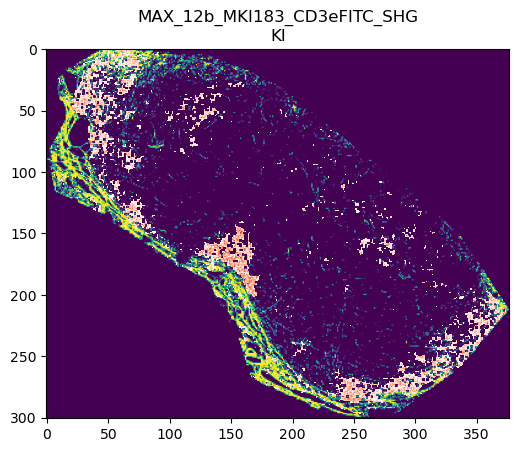

In [10]:
## Cell with density
i = 14
name = dt_cd3_tumor_perfile.index[i]
# Show density
m = ExtractMap.ExtractMap(df_cd3_tumor, "Density20", choose=name)
plt.imshow(m)

# Show T Cells
p = ExtractMap.ExtractMap(df_cd3_tumor, "Cells", choose=name)
p[p == 0] = np.nan
plt.imshow(p, cmap=plt.cm.Reds)
plt.title(f"{dt_cd3_tumor_perfile['Name'].iloc[i]}\n{dt_cd3_tumor_perfile['Condition'].iloc[i]}")
plt.show()

## Comparaison des distribution entre WT et KI (CD64-hDTR)

On s'intéresse ici à la distribution des différents descripteurs selon si le tissu est de phénotype WT (en présence naturel de macrophages) et lorsque le tissu est de phénotype KI (déplété en macrophage).

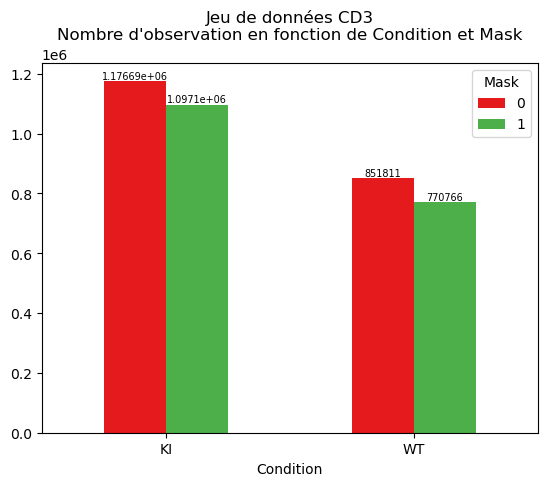

In [129]:
color_nomask = sns.color_palette("Set1")[0]
color_mask = sns.color_palette("Set1")[2]

# Nombre d'observations au sein des classes Condition & Mask
table_cond_mask = pd.crosstab(
    df_cd3_unmask["Condition"],
    df_cd3_unmask["Mask"]
)

ax = table_cond_mask.plot(kind="bar", rot=0, color=[color_nomask, color_mask])
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observation en fonction de Condition et Mask"
)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

TypeError: Patch.__init__() takes 1 positional argument but 2 were given

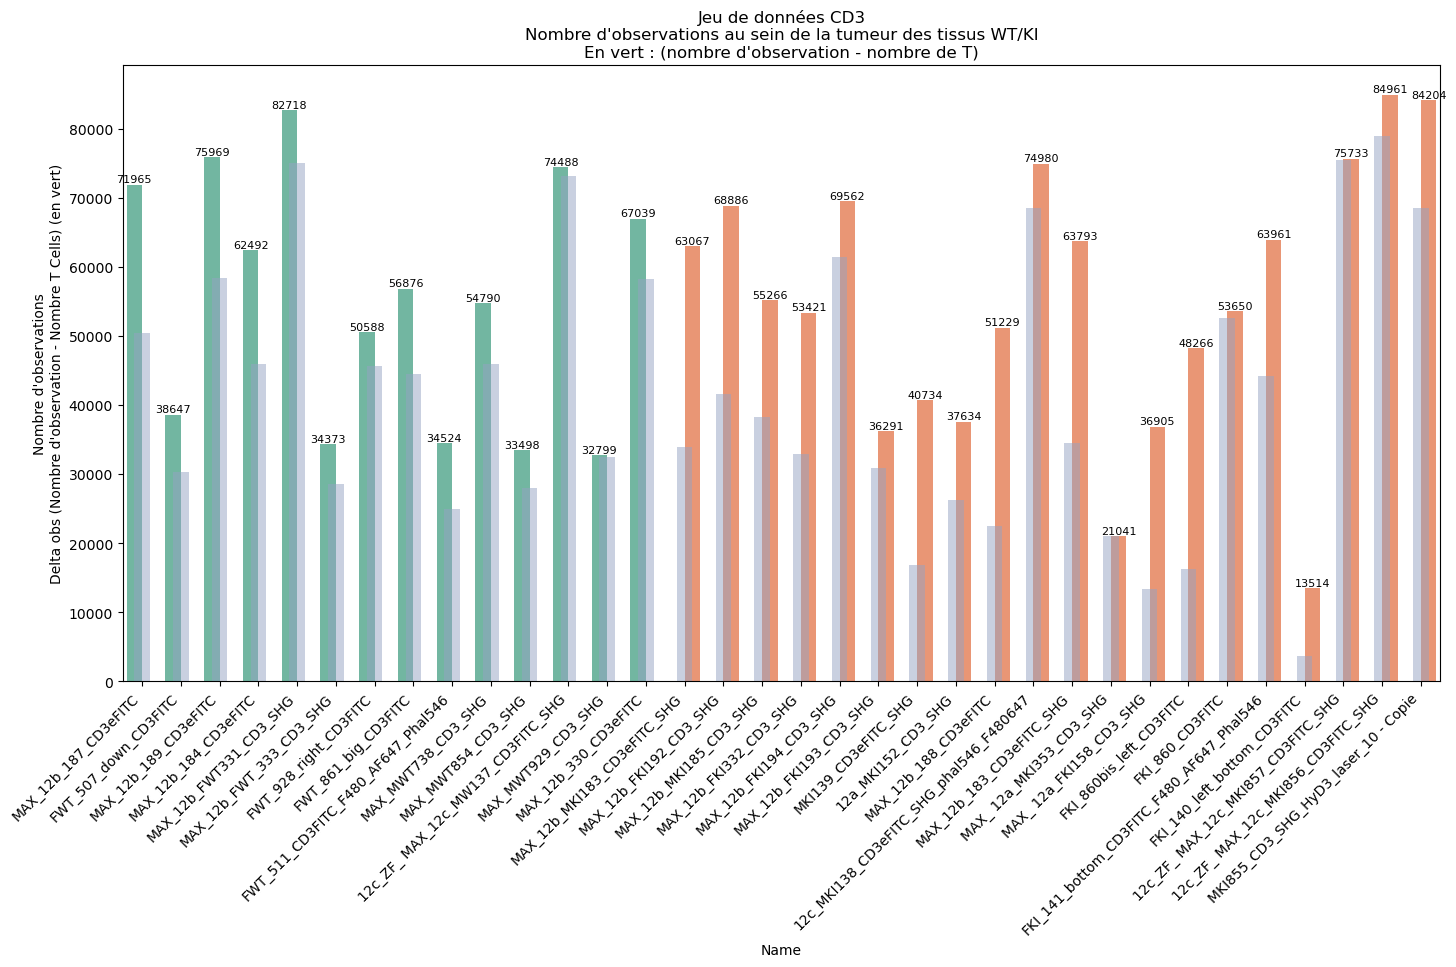

In [176]:
from matplotlib.patches import Patch

color_wt = facecolor=sns.color_palette("Set2")[0]
color_ki = facecolor=sns.color_palette("Set2")[1]

## Number of observation
figs_to_close = []
fig1 = plt.figure(figsize=(17,8))
ax = sns.barplot(data=dt_cd3_tumor_perfile, x="Name", y="Nobs", hue="Condition", palette="Set2")
ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)

# Number of DObs (Observation - T Cells)
ax2 = sns.barplot(data=dt_cd3_tumor_perfile, x="Name", y="DObs", width=0.4,
            alpha=0.5, dodge=False, color=sns.color_palette("Set2")[2])
ax2.get_legend().set_visible(False)
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observations au sein de la tumeur des tissus WT/KI\n"
    "En vert : (nombre d'observation - nombre de T)"
)

plt.ylabel(
    "Nombre d'observations\n"
    "Delta obs (Nombre d'observation - Nombre T Cells) (en vert)"
)
plt.xticks(rotation=45, ha='right')

plt.legend(
    handles=[
        Patch(color_wt, label=WT_lab),
        Patch(facecolor=color_ki, label=KI_lab),
        Patch(facecolor=sns.color_palette("Set2")[2], label='(Nobs - T Cells)')
    ]
)
figs_to_close.append(fig1)

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

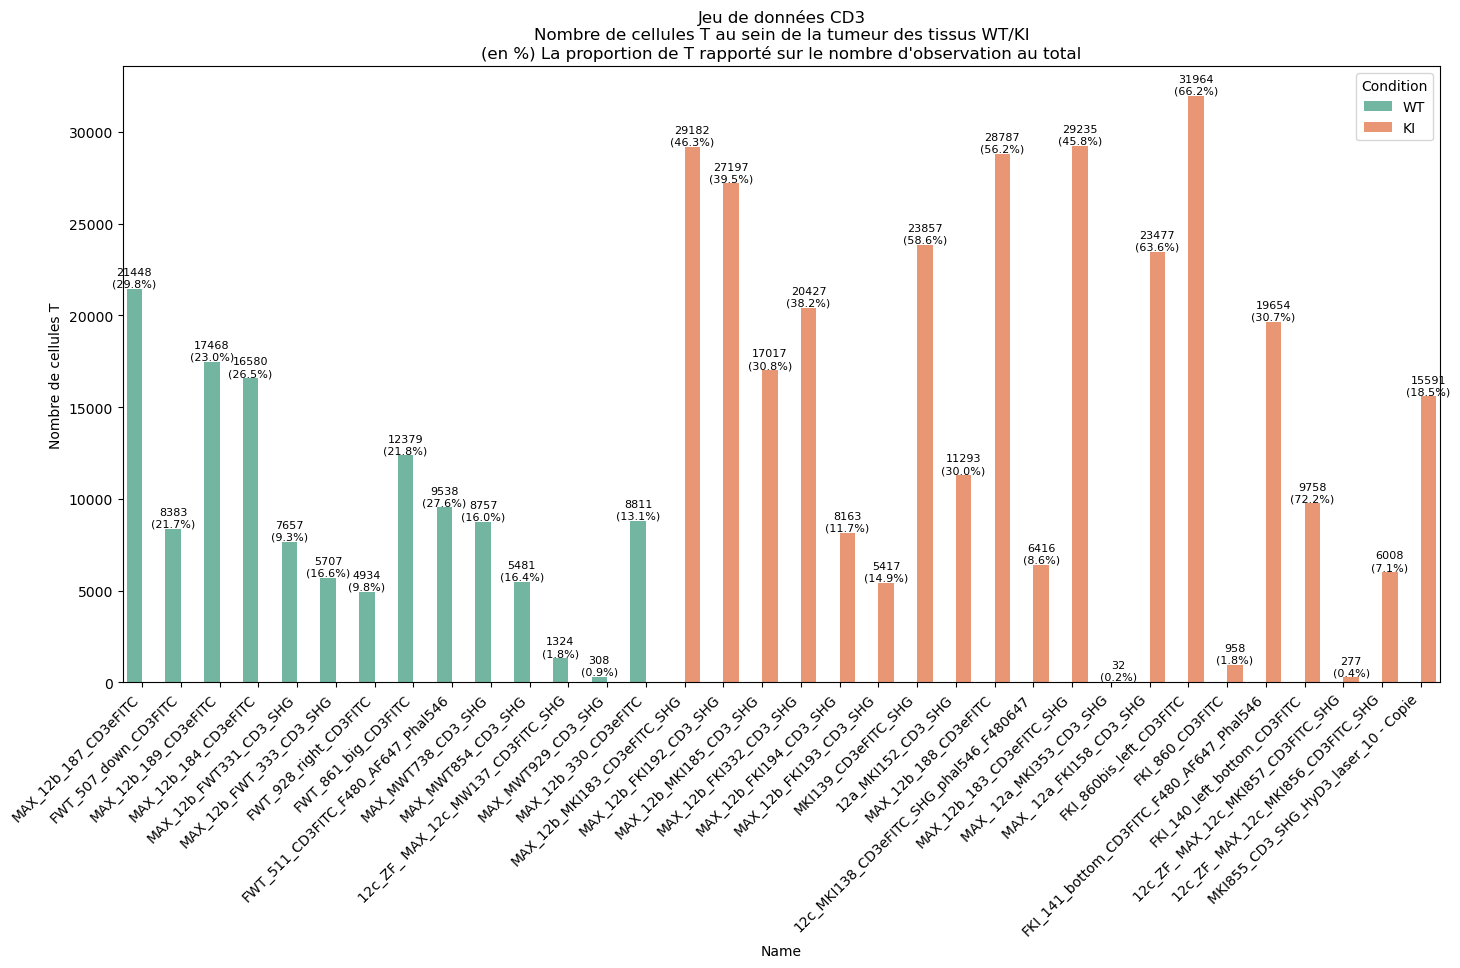

In [13]:
# Number of T Cells
fig2 = plt.figure(figsize=(17, 8))
ax = sns.barplot(data=dt_cd3_tumor_perfile, x="Name", y="Cells", hue="Condition", palette = "Set2")

labels = [f'{v.get_height():.0f}\n'
          f'({dt_cd3_tumor_perfile.iloc[idx]["CellsPercent"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[0])]
ax.bar_label(ax.containers[0], labels=labels, fontsize=8)

labels = [f'{v.get_height():.0f}\n'
          f'({dt_cd3_tumor_perfile.iloc[idx]["CellsPercent"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[1])]
ax.bar_label(ax.containers[1], labels=labels, fontsize=8)

plt.title(
    "Jeu de données CD3\n"
    "Nombre de cellules T au sein de la tumeur des tissus WT/KI\n"
    "(en %) La proportion de T rapporté sur le nombre d'observation au total"
)
plt.ylabel("Nombre de cellules T")
plt.xticks(rotation=45, ha='right')

figs_to_close.append(fig2)

#plots.to_pdf("test1", figs_to_close, bbox_inches="tight")  # Save figures
#[plt.close(fig) for fig in figs_to_close]  # Close figures

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


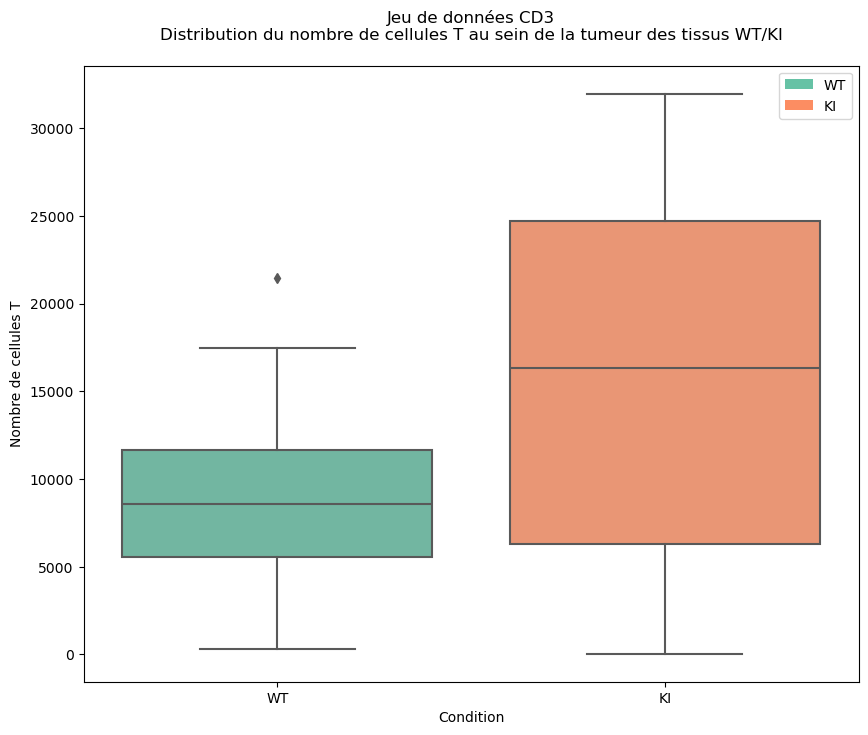

In [131]:
# Boxplot, T Cells number selon la condition
fig3 = plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=dt_cd3_tumor_perfile, x="Condition", y="Cells", palette = "Set2")

plt.title(
    "Jeu de données CD3\n"
    "Distribution du nombre de cellules T au sein de la tumeur des tissus WT/KI\n"
)
plt.ylabel("Nombre de cellules T")
plt.legend(
    handles=[
        Patch(facecolor=color_wt, label=WT_lab),
        Patch(facecolor=color_ki, label=KI_lab),
    ]
)

figs_to_close.append(fig3)

In [15]:
# Statistics
alpha = 0.05
nobs_wt_ki = stats.ttest_ind(
    dt_cd3_tumor_perfile[dt_cd3_tumor_perfile["Condition"] == WT_lab]["Nobs"],
    dt_cd3_tumor_perfile[dt_cd3_tumor_perfile["Condition"] == KI_lab]["Nobs"],
    equal_var = False
)  # No differences between number of value distribution in the two condition

cells_wt_ki = stats.ttest_ind(
    dt_cd3_tumor_perfile[dt_cd3_tumor_perfile["Condition"] == WT_lab]["Cells"],
    dt_cd3_tumor_perfile[dt_cd3_tumor_perfile["Condition"] == KI_lab]["Cells"],
    equal_var = False
)  # There is a significative difference between T-cells distribution depending on the two condition

print("Tests statistiques en fonction des conditions WT/KI")
print(
    f"Par rapport au nombre d'observations :\n\t"
    f"mean_wt={dt_cd3_tumor_perfile[dt_cd3_tumor_perfile['Condition'] == WT_lab]['Nobs'].mean():<10.2f}\t"
    f"mean_ki={dt_cd3_tumor_perfile[dt_cd3_tumor_perfile['Condition'] == KI_lab]['Nobs'].mean():.2f}\t"
    f"p-value={nobs_wt_ki[1]:.4f}\t"
    f"signif={nobs_wt_ki[1]<alpha}\n"
)
print(
    f"Par rapport au nombre de cellules T :\n\t"
    f"mean_wt={dt_cd3_tumor_perfile[dt_cd3_tumor_perfile['Condition'] == WT_lab]['Cells'].mean():<10.2f}\t"
    f"mean_ki={dt_cd3_tumor_perfile[dt_cd3_tumor_perfile['Condition'] == KI_lab]['Cells'].mean():.2f}\t"
    f"p-value={cells_wt_ki[1]:.4f}\t"
    f"signif={cells_wt_ki[1]<alpha}"
)

Tests statistiques en fonction des conditions WT/KI
Par rapport au nombre d'observations :
	mean_wt=55054.71  	mean_ki=54854.90	p-value=0.9757	signif=False

Par rapport au nombre de cellules T :
	mean_wt=9198.21   	mean_ki=15735.50	p-value=0.0311	signif=True


In [16]:
# Save multiple Cells figure to a PDF
def save_cells(df_cd3_tumor, dt_cd3_tumor_perfile, filename="test.pdf", then_close=True):
    figs_to_close = []
    for idx, name in enumerate(dt_cd3_tumor_perfile.index):
        # Show Tumor Cell
        fig = plt.figure(figsize=(10, 8))
        m = ExtractMap.ExtractMap(df_cd3_tumor, "Density20", choose=name)
        plt.imshow(m)
        # Show T Cells
        p = ExtractMap.ExtractMap(df_cd3_tumor, "Cells", choose=name)
        p[p == 0] = np.nan
        plt.imshow(p, cmap=plt.cm.Reds)
        # Title label
        p_name = dt_cd3_tumor_perfile['Name'].iloc[idx]
        p_condition = dt_cd3_tumor_perfile['Condition'].iloc[idx]
        p_nobs = dt_cd3_tumor_perfile['Nobs'].iloc[idx]
        p_tcells = dt_cd3_tumor_perfile['Cells'].iloc[idx]
        p_tcells_prop = dt_cd3_tumor_perfile['CellsPercent'].iloc[idx]*100
        plt.title(
            f"{p_condition}\n"
            f"{p_name}\n"
            f"Nombre d'observations : {p_nobs} ; "
            f"Nombre de T : {p_tcells:.0f} ({p_tcells_prop:.2f}%)"
        )
        figs_to_close.append(fig)
    
    plots.to_pdf(filename, figs_to_close)
    if then_close:
        [plt.close(f) for f in figs_to_close]

#save_cells(df_cd3_tumor, dt_cd3_tumor_perfile, filename="test.pdf")

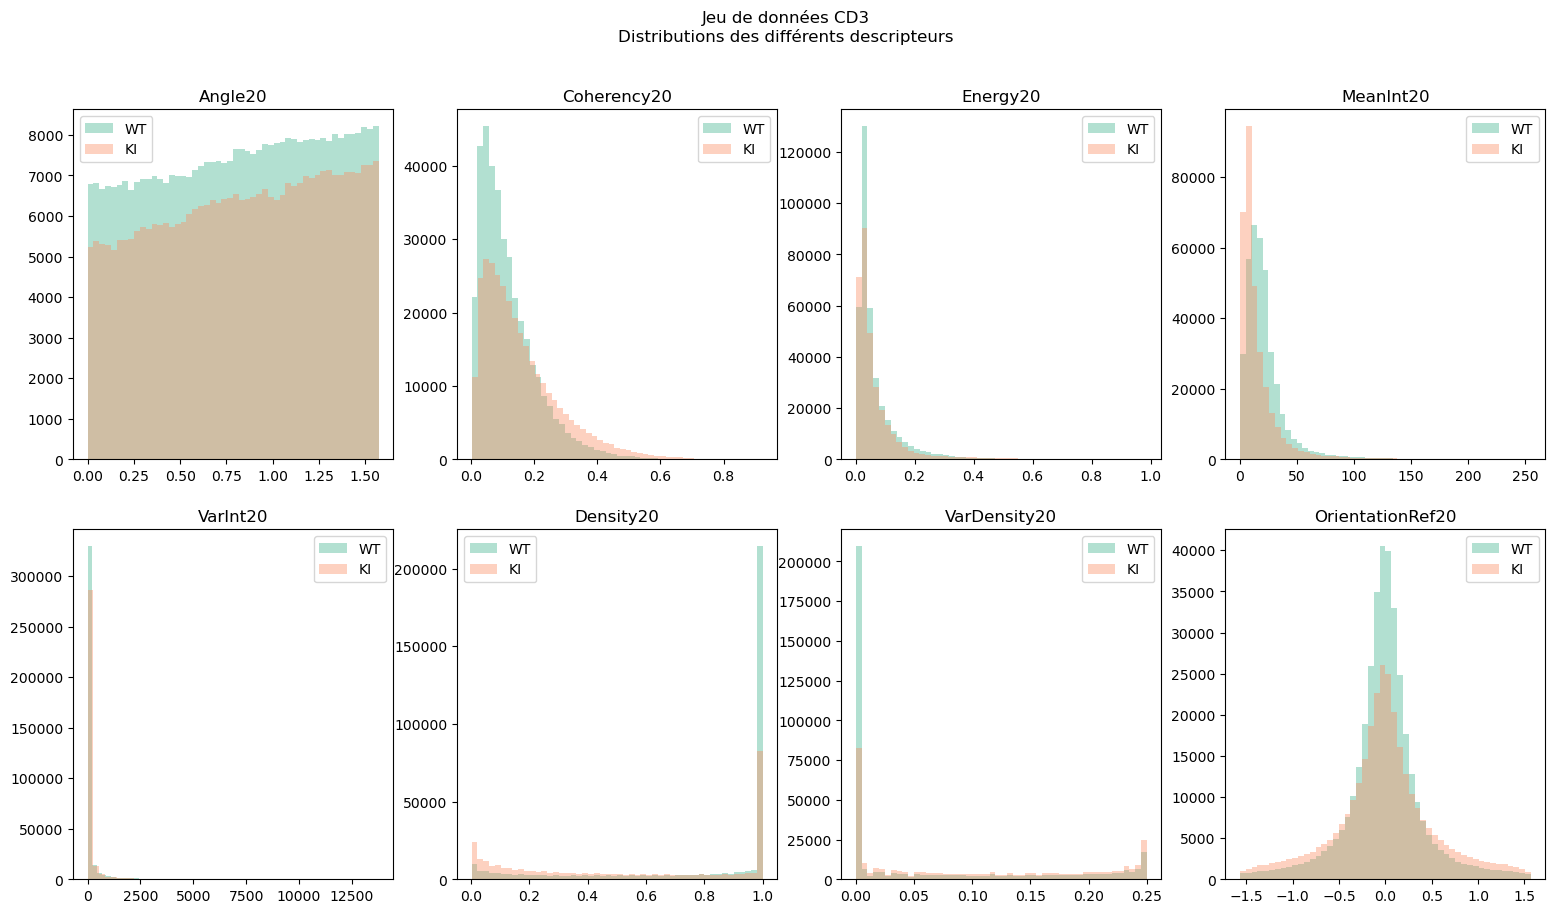

In [17]:
pixel_size = 20
descriptors = ["Angle", "Coherency", "Energy", "MeanInt", "VarInt", "Density", "VarDensity", "OrientationRef"]
descriptors = [i+str(pixel_size) for i in descriptors]
fig, ax = plt.subplots(2, i2:=4, figsize=(19, 10))
fig.suptitle("Jeu de données CD3\n"
             "Distributions des différents descripteurs")

df_tmp = df_cd3_tumor[df_cd3_tumor["Density20"] > 0]
for i, des in enumerate(descriptors):
    idx0, idx1 = i//i2, i%i2
    actual_axis = ax[idx0][idx1]
    actual_axis.hist(df_tmp[df_tmp["Condition"] == WT_lab][des], label=WT_lab, bins=50, alpha=0.5, color=color_wt)
    actual_axis.hist(df_tmp[df_tmp["Condition"] == KI_lab][des], label=KI_lab, bins=50, alpha=0.4, color=color_ki)
    actual_axis.set_title(des)
    actual_axis.legend()

plt.show()

## Zones T+ ou enrichies en T

Les zones enrichies en T sont des régions peuplés en cellules immunitaires. Elle est définie lorsque le nombre de cellules immunitaires à 100um est supérieur à la moyenne de cette distribution.  
Les zones T+ sont les régions pour lequel le nombre de cellules immunitaires à 100um est supérieur à 0.

In [112]:
# Mask
mask_wt = df_cd3_tumor["Condition"] == WT_lab
mask_ki = df_cd3_tumor["Condition"] == KI_lab
mask_density = df_cd3_tumor["Density20"] > 0
mask_t_enriched = (df_cd3_tumor["Cells100um"] > df_cd3_tumor["Cells100um"].mean())
mask_t_plus = (df_cd3_tumor["Cells100um"] > 0)
# Color
color_t_plus = sns.color_palette("Set2")[4]
color_t_enriched = sns.color_palette("Set2")[7]

In [19]:
# Create new dataframe with class attributes
df_cd3_zones = df_cd3_tumor.copy()
df_cd3_zones["class_t_plus"] = 0
df_cd3_zones["class_t_enriched"] = 0
# Specify class
df_cd3_zones.loc[mask_t_plus, "class_t_plus"] = 1
df_cd3_zones.loc[mask_t_enriched, "class_t_enriched"] = 1
df_cd3_zones

,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac,class_t_plus,class_t_enriched
107048,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,625,0.000861,1.427000e-07,0.000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
107205,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4867,665,0.000544,1.417000e-07,0.000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
107206,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4907,665,0.000784,1.593000e-07,0.000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
107207,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4947,665,0.001000,1.978000e-07,0.000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
107208,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,665,0.002000,2.550000e-07,0.000,0.000,0.000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708879,KI,./MKI855_CD3_SHG_HyD3_laser_10 - Copie.tif_SHG...,9513,16517,0.084000,2.980000e-01,32.769,271.830,0.947,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.991081,0,0
3708880,KI,./MKI855_CD3_SHG_HyD3_laser_10 - Copie.tif_SHG...,9553,16517,0.084000,2.900000e-01,46.533,499.634,0.999,0.000636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.997612,0,0
3708881,KI,./MKI855_CD3_SHG_HyD3_laser_10 - Copie.tif_SHG...,9593,16517,0.085000,2.820000e-01,53.496,470.186,0.996,0.004000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.995087,0,0
3708882,KI,./MKI855_CD3_SHG_HyD3_laser_10 - Copie.tif_SHG...,9633,16517,0.088000,2.730000e-01,54.625,425.351,0.999,0.001000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.996892,0,0


In [51]:
plus_count = df_cd3_zones["class_t_plus"].value_counts().to_frame()\
    .reset_index(level=0)\
    .rename(columns={"count": "count_t_plus", "class_t_plus": "class"})\
    .sort_values(by=["class"], ascending=True)

enriched_count = df_cd3_zones["class_t_enriched"].value_counts().to_frame()\
    .reset_index(level=0)\
    .rename(columns={"count": "count_t_enriched", "class_t_enriched": "class"})\
    .sort_values(by=["class"], ascending=True)

df_cd3_class_count = plus_count
df_cd3_class_count["count_t_enriched"] = enriched_count["count_t_enriched"].values
df_cd3_class_count

,class,count_t_plus,count_t_enriched
1,0,509258,1356213
0,1,1358606,511651


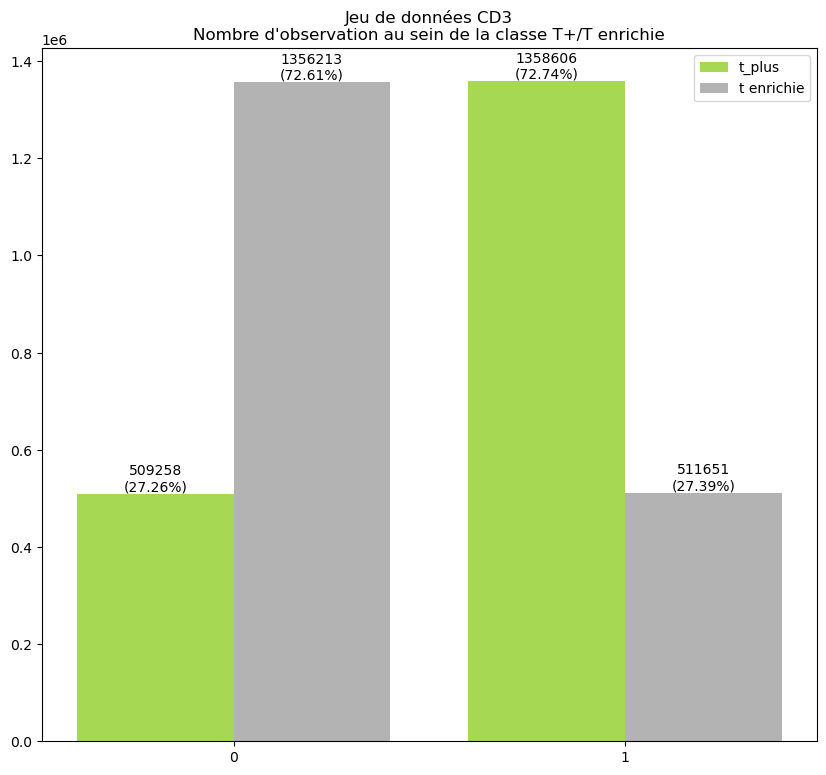

In [60]:
width = 0.4
fig, ax = plt.subplots(figsize=(10, 9))
ax.bar(df_cd3_class_count["class"]-width/2, df_cd3_class_count["count_t_plus"], width=width, label="t_plus", color=color_t_plus)
ax.bar(df_cd3_class_count["class"]+width/2, df_cd3_class_count["count_t_enriched"], width=width, label="t enrichie", color=color_t_enriched)
plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observation au sein de la classe T+/T enrichie"
)
ax.bar_label(ax.containers[0], fontsize=10, fmt=lambda k: f"{k:.0f}\n({100*k/df_cd3_zones.shape[0]:.2f}%)")
ax.bar_label(ax.containers[1], fontsize=10, fmt=lambda k: f"{k:.0f}\n({100*k/df_cd3_zones.shape[0]:.2f}%)")
plt.xticks(df_cd3_class_count["class"])
plt.legend()
plt.show()

In [22]:
# Seulement sur WT/ Seulement sur CD64/ Les Deux
# WT / CD64
# t_enriched / t_plus
# Neutrophiles

**Au sein de chaque image, quel est le nombre d'observations T+ et T enrichies**

In [23]:
# Number of observations per file
dt_zones_byfile = df_cd3_zones[["FileName", "Condition"]]\
    .groupby(["FileName"]).value_counts().to_frame()\
    .reset_index(level=1).sort_values(by="Condition", ascending=False)\
    .rename(columns={"count": "Nobs"})

dt_zones_byfile = dt_zones_byfile.join(
    df_cd3_zones[["FileName", "Cells"]].groupby(["FileName"]).sum()
)

dt_zones_byfile["Name"] = [filename[2:filename.find(".tif")] for filename in dt_zones_byfile.index]  # Add Name column

# Add class count
tmp1 = df_cd3_zones[["FileName", "class_t_plus"]].groupby(["FileName"])\
    .value_counts().to_frame().reset_index(level=1).rename(columns={"count": "count_t_plus"})

tmp2 = df_cd3_zones[["FileName", "class_t_enriched"]].groupby(["FileName"])\
    .value_counts().to_frame().reset_index(level=1).rename(columns={"count": "count_t_enriched"})

# Join count to dataframe
dt_zones_byfile = dt_zones_byfile.join(
    tmp1[tmp1["class_t_plus"] == 1]["count_t_plus"]
)
dt_zones_byfile = dt_zones_byfile.join(
    tmp2[tmp2["class_t_enriched"] == 1]["count_t_enriched"]
)
dt_zones_byfile[~(dt_zones_byfile == dt_zones_byfile)] = 0  # replace NaN by 0
dt_zones_byfile["percent_t_plus"] = dt_zones_byfile["count_t_plus"]/dt_zones_byfile["Nobs"]
dt_zones_byfile["percent_t_enriched"] = dt_zones_byfile["count_t_enriched"]/dt_zones_byfile["Nobs"]
dt_zones_byfile

,Condition,Nobs,Cells,Name,count_t_plus,count_t_enriched,percent_t_plus,percent_t_enriched
FileName,,,,,,,,
./MAX_12b_187_CD3eFITC.tif_SHG.tif,WT,71965,21448.0,MAX_12b_187_CD3eFITC,61676,27224.0,0.857028,0.378295
./FWT_507_down_CD3FITC.tif_max.tif_SHG.tif,WT,38647,8383.0,FWT_507_down_CD3FITC,30932,10605.0,0.800373,0.274407
./MAX_12b_189_CD3eFITC.tif_SHG.tif,WT,75969,17468.0,MAX_12b_189_CD3eFITC,64343,21514.0,0.846964,0.283194
./MAX_12b_184_CD3eFITC.tif_SHG.tif,WT,62492,16580.0,MAX_12b_184_CD3eFITC,55833,21751.0,0.893442,0.348061
./MAX_12b_FWT331_CD3_SHG.tif,WT,82718,7657.0,MAX_12b_FWT331_CD3_SHG,64235,10390.0,0.776554,0.125607
./MAX_12b_FWT_333_CD3_SHG.tif,WT,34373,5707.0,MAX_12b_FWT_333_CD3_SHG,25631,7473.0,0.745672,0.217409
./FWT_928_right_CD3FITC.tif_max.tif_SHG.tif,WT,50588,4934.0,FWT_928_right_CD3FITC,32443,7399.0,0.641318,0.146260
./FWT_861_big_CD3FITC.tif_max.tif_SHG.tif,WT,56876,12379.0,FWT_861_big_CD3FITC,44141,14551.0,0.776092,0.255837
./FWT_511_CD3FITC_F480_AF647_Phal546.tif_max.tif_SHG.tif,WT,34524,9538.0,FWT_511_CD3FITC_F480_AF647_Phal546,29612,12671.0,0.857722,0.367020


**Nombre de cellules T au sein des différentes classes**

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

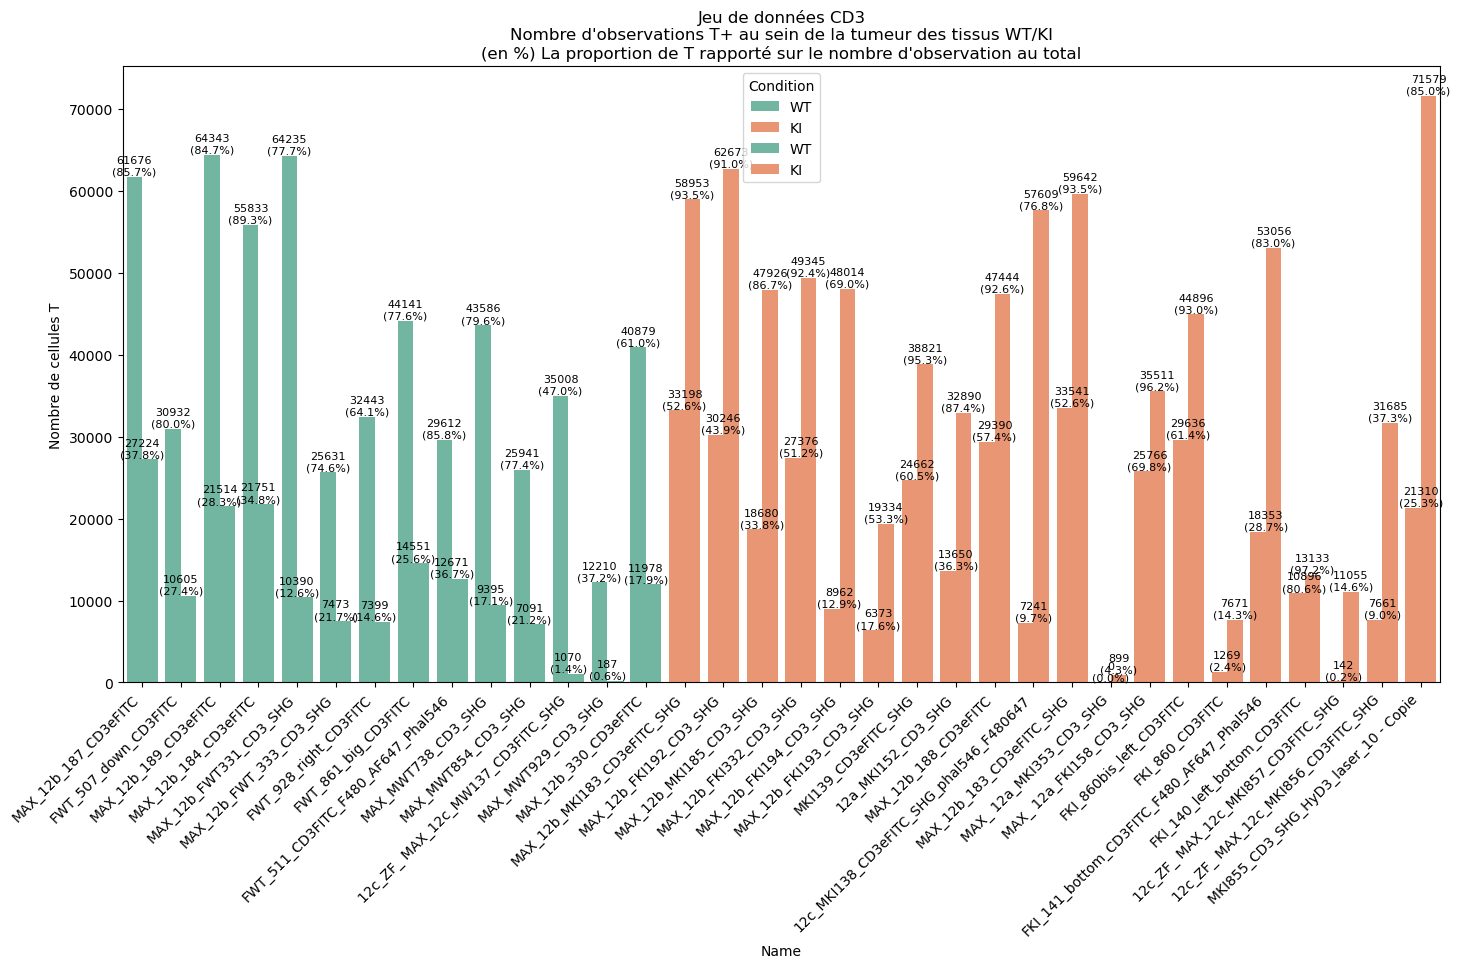

In [153]:
# Number of T Cells
fig2, ax = plt.subplots(figsize=(17, 8))
sns.barplot(ax=ax, data=dt_zones_byfile, x="Name", y="count_t_plus", hue="Condition", palette = "Set2")

labels = [f'{v.get_height():.0f}\n'
          f'({dt_zones_byfile.iloc[idx]["percent_t_plus"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[0])]
ax.bar_label(ax.containers[0], labels=labels, fontsize=8)

labels = [f'{v.get_height():.0f}\n'
          f'({dt_zones_byfile.iloc[idx]["percent_t_plus"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[1])]
ax.bar_label(ax.containers[1], labels=labels, fontsize=8)

sns.barplot(ax=ax, data=dt_zones_byfile, x="Name", y="count_t_enriched", hue="Condition", palette = "Set2", dodge=False)
labels = [f'{v.get_height():.0f}\n'
          f'({dt_zones_byfile.iloc[idx]["percent_t_enriched"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[2])]
ax.bar_label(ax.containers[2], labels=labels, fontsize=8)

labels = [f'{v.get_height():.0f}\n'
          f'({dt_zones_byfile.iloc[idx]["percent_t_enriched"]*100:.1f}%)'\
          for idx, v in enumerate(ax.containers[3])]
ax.bar_label(ax.containers[3], labels=labels, fontsize=8)

plt.title(
    "Jeu de données CD3\n"
    "Nombre d'observations T+ au sein de la tumeur des tissus WT/KI\n"
    "(en %) La proportion de T rapporté sur le nombre d'observation au total"
)
plt.ylabel("Nombre de cellules T")
plt.xticks(rotation=45, ha='right')

figs_to_close.append(fig2)

#plots.to_pdf("test1", figs_to_close, bbox_inches="tight")  # Save figures
#[plt.close(fig) for fig in figs_to_close]  # Close figures

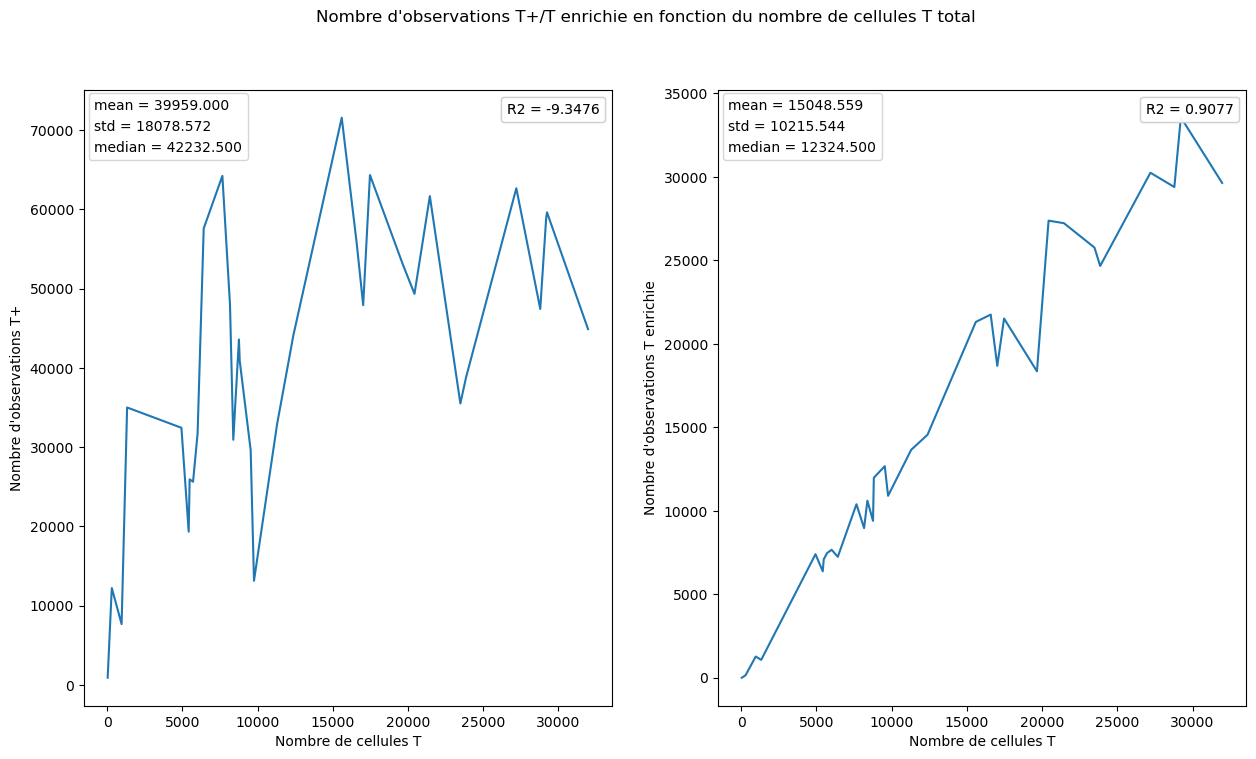

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.single_plot(
    xvalues=dt_zones_byfile.sort_values(by=["Cells"], ascending=False)["Cells"],
    yvalues=dt_zones_byfile.sort_values(by=["Cells"], ascending=False)["count_t_plus"],
    xlabel="Nombre de cellules T", ylabel="Nombre d'observations T+",
    figure=(fig, ax1), anchor_x=0.16, anchor_y=0.94
)
plots.single_plot(
    xvalues=dt_zones_byfile.sort_values(by=["Cells"], ascending=False)["Cells"],
    yvalues=dt_zones_byfile.sort_values(by=["Cells"], ascending=False)["count_t_enriched"],
    xlabel="Nombre de cellules T", ylabel="Nombre d'observations T enrichie",
    figure=(fig, ax2), anchor_x=0.16, anchor_y=0.94
)
fig.suptitle("Nombre d'observations T+/T enrichie en fonction du nombre de cellules T total")
plt.show()

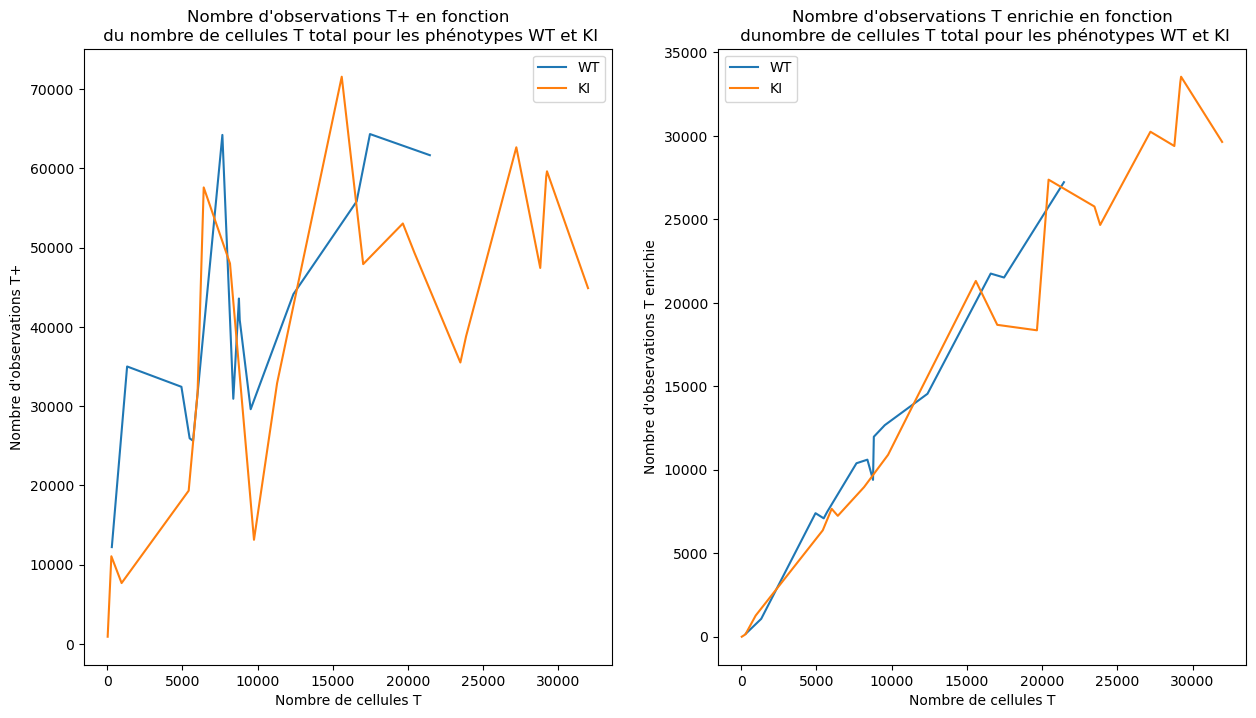

In [104]:
# En fonction du phénotype WT/KI
mask_wt = dt_zones_byfile["Condition"] == WT_lab
mask_ki = dt_zones_byfile["Condition"] == KI_lab
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(
    dt_zones_byfile[mask_wt].sort_values(by=["Cells"], ascending=False)["Cells"],
    dt_zones_byfile[mask_wt].sort_values(by=["Cells"], ascending=False)["count_t_plus"],
    label=WT_lab
)
ax1.plot(
    dt_zones_byfile[mask_ki].sort_values(by=["Cells"], ascending=False)["Cells"],
    dt_zones_byfile[mask_ki].sort_values(by=["Cells"], ascending=False)["count_t_plus"],
    label=KI_lab
)
ax1.set_xlabel("Nombre de cellules T")
ax1.set_ylabel("Nombre d'observations T+")
ax1.set_title(
    "Nombre d'observations T+ en fonction\n du "
    "nombre de cellules T total pour les phénotypes WT et KI"
)
ax1.legend()
#
ax2.plot(
    dt_zones_byfile[mask_wt].sort_values(by=["Cells"], ascending=False)["Cells"],
    dt_zones_byfile[mask_wt].sort_values(by=["Cells"], ascending=False)["count_t_enriched"],
    label=WT_lab
)
ax2.plot(
    dt_zones_byfile[mask_ki].sort_values(by=["Cells"], ascending=False)["Cells"],
    dt_zones_byfile[mask_ki].sort_values(by=["Cells"], ascending=False)["count_t_enriched"],
    label=KI_lab
)
ax2.set_xlabel("Nombre de cellules T")
ax2.set_ylabel("Nombre d'observations T enrichie")
ax2.set_title(
    "Nombre d'observations T enrichie en fonction\n du"
    "nombre de cellules T total pour les phénotypes WT et KI"
)
ax2.legend()
plt.show()

In [76]:
# Table
table_cd3 = df_cd3_tumor["Cells"].value_counts().to_frame().reset_index(level=0)["Cells"].to_frame()
table_cd3["count_density"] = df_cd3_tumor[mask_density]["Cells"].value_counts().values
table_cd3["count_t_enriched"] = df_cd3_tumor[mask_t_enriched]["Cells"].value_counts().values

table_cd3 = table_cd3.join(
    df_cd3_tumor[mask_t_plus]["Cells"].value_counts().to_frame().rename(columns={"count": "count_t_plus"})
)
table_cd3 = table_cd3.join(
    df_cd3_tumor[~mask_t_plus]["Cells"].value_counts().to_frame().rename(columns={"count": "count_t_negatif"})
)
table_cd3[np.isnan(table_cd3)] = 0
table_cd3

,Cells,count_density,count_t_enriched,count_t_plus,count_t_negatif
0.0,0.0,539173,259257,1060683,509258.0
1.0,1.0,92695,150391,192988,0.0
2.0,2.0,37977,69863,72666,0.0
3.0,3.0,13333,24957,25082,0.0
4.0,4.0,3219,6131,6135,0.0
5.0,5.0,483,941,941,0.0
6.0,6.0,49,104,104,0.0
7.0,7.0,3,6,6,0.0
8.0,8.0,1,1,1,0.0


In [148]:
# Statistics on T cells
q_percent = [0, 0.25, 0.5, 0.75, 1]

# all
t_mean = df_cd3_tumor["Cells"].mean()
t_median = df_cd3_tumor["Cells"].median()
t_quantile = np.quantile(df_cd3_tumor["Cells"], q_percent)

# wt
t_mean_wt = df_cd3_tumor[mask_wt]["Cells"].mean()
t_median_wt = df_cd3_tumor[mask_wt]["Cells"].median()
t_quantile_wt = np.quantile(df_cd3_tumor[mask_wt]["Cells"], q_percent)

# ki
t_mean_ki = df_cd3_tumor[mask_ki]["Cells"].mean()
t_median_ki = df_cd3_tumor[mask_ki]["Cells"].median()
t_quantile_ki = np.quantile(df_cd3_tumor[mask_ki]["Cells"], q_percent)

# density
t_mean_density = df_cd3_tumor[mask_density]["Cells"].mean()
t_median_density = df_cd3_tumor[mask_density]["Cells"].median()
t_quantile_density = np.quantile(df_cd3_tumor[mask_density]["Cells"], q_percent)

# density & wt
t_mean_density_wt = df_cd3_tumor[mask_density & mask_wt]["Cells"].mean()
t_median_density_wt = df_cd3_tumor[mask_density & mask_wt]["Cells"].median()
t_quantile_density_wt = np.quantile(df_cd3_tumor[mask_density & mask_wt]["Cells"], q_percent)

# density & ki
t_mean_density_ki = df_cd3_tumor[mask_density & mask_ki]["Cells"].mean()
t_median_density_ki = df_cd3_tumor[mask_density & mask_ki]["Cells"].median()
t_quantile_density_ki = np.quantile(df_cd3_tumor[mask_density & mask_ki]["Cells"], q_percent)

# T Cells
print(
    "----In tumor----\n\n"
    f"Stats sur le nombre de cellules T:\n"
    f"(All)\t mean={t_mean:<10.2f}median={t_median:<10.2f}\t\n"
    f"(WT)\t mean={t_mean_wt:<10.2f}median={t_median_wt:<10.2f}\t\n"
    f"(KI)\t mean={t_mean_ki:<10.2f}median={t_median_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile_ki] ; print()
print()

# T Cells
print(
    "---In tumor---Density20 > 0----\n\n"
    f"Stats sur le nombre de cellules T:\n"
    f"(All)\t mean={t_mean_density:<10.2f}median={t_median_density:<10.2f}\t\n"
    f"(WT)\t mean={t_mean_density_wt:<10.2f}median={t_median_density_wt:<10.2f}\t\n"
    f"(KI)\t mean={t_mean_density_ki:<10.2f}median={t_median_density_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile_density] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile_density_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in t_quantile_density_ki] ; print()
print()

# TODO : retrieve p-value
cells_plus_enriched = stats.chi2_contingency(table_cd3[["count_t_plus", "count_t_enriched"]].T)
#cells_plus_enriched

----In tumor----

Stats sur le nombre de cellules T:
(All)	 mean=0.24      median=0.00      	
(WT)	 mean=0.17      median=0.00      	
(KI)	 mean=0.29      median=0.00      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)         0.00     0.00     0.00     0.00     8.00   
(WT)          0.00     0.00     0.00     0.00     6.00   
(KI)          0.00     0.00     0.00     0.00     8.00   

---In tumor---Density20 > 0----

Stats sur le nombre de cellules T:
(All)	 mean=0.33      median=0.00      	
(WT)	 mean=0.24      median=0.00      	
(KI)	 mean=0.43      median=0.00      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)         0.00     0.00     0.00     0.00     8.00   
(WT)          0.00     0.00     0.00     0.00     6.00   
(KI)          0.00     0.00     0.00     1.00     8.00   



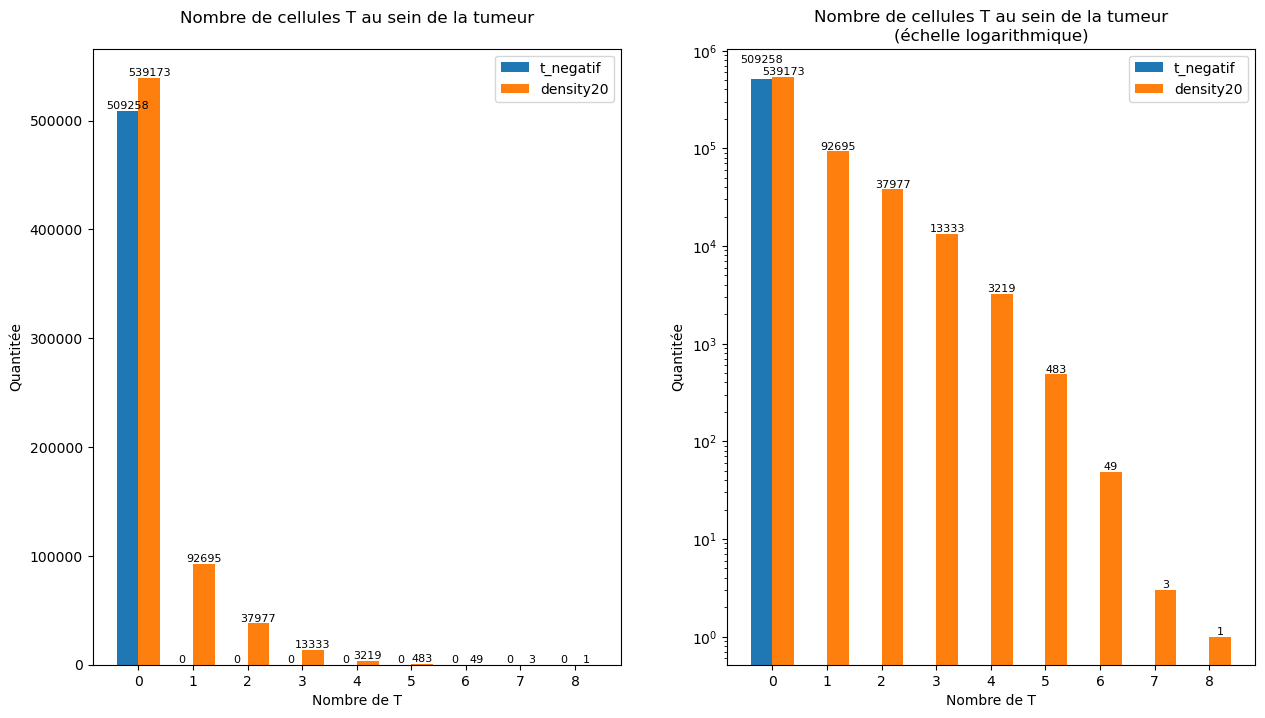

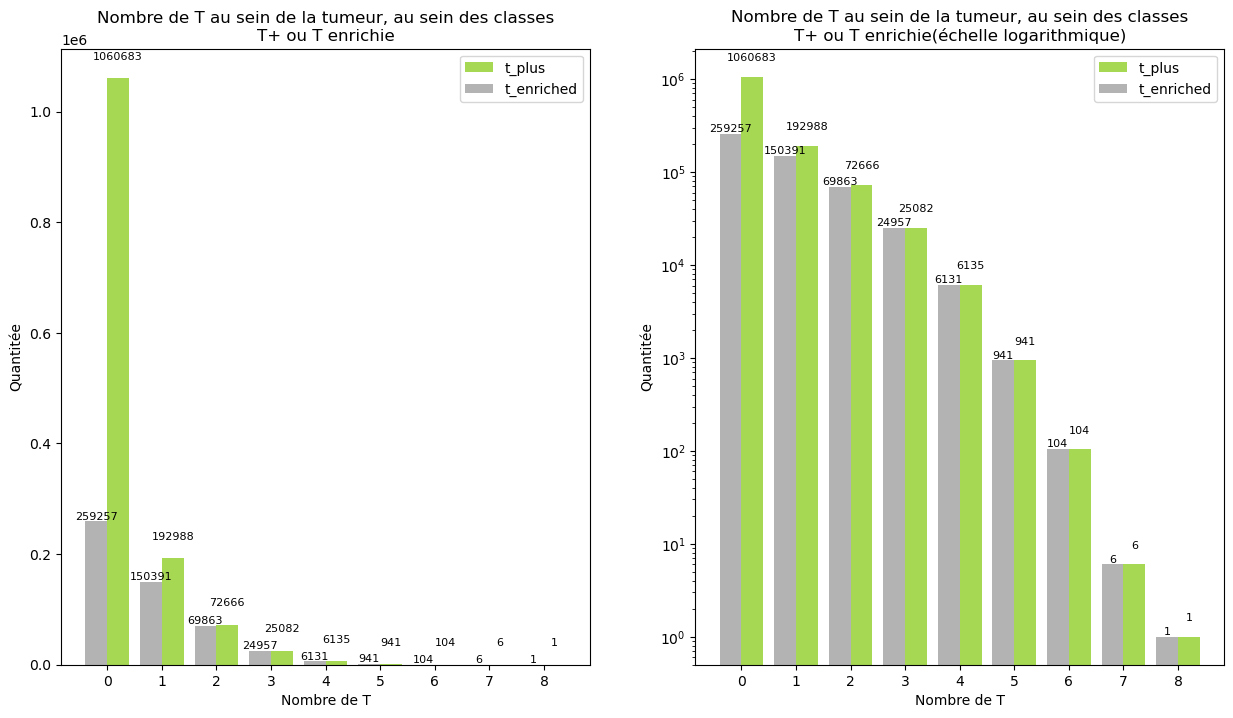

In [132]:
width = 0.4
## Number of observation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.bar(table_cd3["Cells"]-width/2, table_cd3["count_t_negatif"], width=width, label="t_negatif")
ax1.bar(table_cd3["Cells"]+width/2, table_cd3["count_density"], width=width, label="density20")
ax1.bar_label(ax1.containers[0], fontsize=8)
ax1.bar_label(ax1.containers[1], fontsize=8)
ax1.set_xticks(table_cd3["Cells"])
ax1.legend()

ax1.set_title("Nombre de cellules T au sein de la tumeur\n")
ax1.set_xlabel("Nombre de T")
ax1.set_ylabel("Quantitée")

ax2.bar(table_cd3["Cells"]+-width/2, table_cd3["count_t_negatif"], width=width, label="t_negatif")
ax2.bar(table_cd3["Cells"]+width/2, table_cd3["count_density"], width=width, label="density20")
ax2.bar_label(ax1.containers[0], padding=10, fontsize=8)
ax2.bar_label(ax1.containers[1], fontsize=8)
ax2.set_xticks(table_cd3["Cells"])
ax2.legend()
ax2.set_yscale("log")

ax2.set_title(
    "Nombre de cellules T au sein de la tumeur\n"
    "(échelle logarithmique)"
)
ax2.set_xlabel("Nombre de T")
ax2.set_ylabel("Quantitée")
plt.show()

## On t_enriched & t_plus
width = 0.4
## Number of observation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.bar(table_cd3["Cells"]+width/2, table_cd3["count_t_plus"], width=width, color=color_t_plus, label="t_plus")
ax1.bar(table_cd3["Cells"]+-width/2, table_cd3["count_t_enriched"], width=width, color=color_t_enriched, label="t_enriched")
ax1.bar_label(ax1.containers[0], padding=12, fontsize=8, fmt=lambda k: f"{k:.0f}")
ax1.bar_label(ax1.containers[1], fontsize=8, fmt=lambda k: f"{k:.0f}")
ax1.set_xticks(table_cd3["Cells"])
ax1.legend()

ax1.set_title("Nombre de T au sein de la tumeur, au sein des classes\nT+ ou T enrichie")
ax1.set_xlabel("Nombre de T")
ax1.set_ylabel("Quantitée")

ax2.bar(
    table_cd3["Cells"]+width/2, table_cd3["count_t_plus"], width=width, color=color_t_plus, label="t_plus"
)
ax2.bar(
    table_cd3["Cells"]+-width/2, table_cd3["count_t_enriched"], width=width, color=color_t_enriched, label="t_enriched"
)
ax2.bar_label(ax2.containers[0],  padding=10, fontsize=8, fmt=lambda k: f"{k:.0f}")
ax2.bar_label(ax2.containers[1], fontsize=8, fmt=lambda k: f"{k:.0f}")
ax2.set_xticks(table_cd3["Cells"])
ax2.legend()
ax2.set_yscale("log")

ax2.set_title(
    "Nombre de T au sein de la tumeur, au sein des classes\nT+ ou T enrichie\n"
    "(échelle logarithmique)"
)
ax2.set_xlabel("Nombre de T")
ax2.set_ylabel("Quantitée")
plt.show()

In [144]:
# Statistics on Cells number at 100um from a position
q_percent = [0, 0.25, 0.5, 0.75, 1] 
# all
cells100_mean = df_cd3_tumor["Cells100um"].mean()
cells100_median = df_cd3_tumor["Cells100um"].median()
cells100_quantile = np.quantile(df_cd3_tumor["Cells100um"], q_percent)

# wt
cells100_mean_wt = df_cd3_tumor[mask_wt]["Cells100um"].mean()
cells100_median_wt = df_cd3_tumor[mask_wt]["Cells100um"].median()
cells100_quantile_wt = np.quantile(df_cd3_tumor[mask_wt]["Cells100um"], q_percent)

# ki
cells100_mean_ki = df_cd3_tumor[mask_ki]["Cells100um"].mean()
cells100_median_ki = df_cd3_tumor[mask_ki]["Cells100um"].median()
cells100_quantile_ki = np.quantile(df_cd3_tumor[mask_ki]["Cells100um"], q_percent)


# density20 > 0
cells100_mean_density = df_cd3_tumor[mask_density]["Cells100um"].mean()
cells100_median_density = df_cd3_tumor[mask_density]["Cells100um"].median()
cells100_quantile_density = np.quantile(df_cd3_tumor[mask_density]["Cells100um"], q_percent)

# density20 > 0 & wt
cells100_mean_density_wt = df_cd3_tumor[mask_density & mask_wt]["Cells100um"].mean()
cells100_median_density_wt = df_cd3_tumor[mask_density & mask_wt]["Cells100um"].median()
cells100_quantile_density_wt = np.quantile(df_cd3_tumor[mask_density & mask_wt]["Cells100um"], q_percent)

# density20 > 0 & ki
cells100_mean_density_ki = df_cd3_tumor[mask_density & mask_ki]["Cells100um"].mean()
cells100_median_density_ki = df_cd3_tumor[mask_density & mask_ki]["Cells100um"].median()
cells100_quantile_density_ki = np.quantile(df_cd3_tumor[mask_density & mask_ki]["Cells100um"], q_percent)

#
print(
    "----In tumor----\n"
    f"Stats sur le nombre de cellules à 100um :\n"
    f"(All)\t mean={cells100_mean:<10.2f}median={cells100_median:<10.2f}\t\n"
    f"(WT)\t mean={cells100_mean_wt:<10.2f}median={cells100_median_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100_mean_ki:<10.2f}median={cells100_median_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile_ki] ; print()
print()
#
print(
    "---In tumor---Density20 > 0----\n\n"
    f"Stats sur le nombre de cellules à 100um :\n"
    f"(All)\t mean={cells100_mean_density:<10.2f}median={cells100_median_density:<10.2f}\t\n"
    f"(WT)\t mean={cells100_mean_density_wt:<10.2f}median={cells100_median_density_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100_mean_density_ki:<10.2f}median={cells100_median_density_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile_density] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile_density_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100_quantile_density_ki] ; print()

# TODO : Quantile cumulative

----In tumor----
Stats sur le nombre de cellules à 100um :
(All)	 mean=7.08      median=1.21      	
(WT)	 mean=4.97      median=1.21      	
(KI)	 mean=8.56      median=2.42      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)        -0.00     0.00     1.21     7.26   101.64   
(WT)         -0.00     0.00     1.21     4.84   101.64   
(KI)         -0.00     0.00     2.42     9.68   101.64   

---In tumor---Density20 > 0----

Stats sur le nombre de cellules à 100um :
(All)	 mean=9.62      median=2.42      	
(WT)	 mean=7.13      median=2.42      	
(KI)	 mean=12.54     median=4.84      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)        -0.00     0.00     2.42    13.31   101.64   
(WT)         -0.00     0.00     2.42     9.68   101.64   
(KI)         -0.00     0.00     4.84    19.36   100.43   


/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

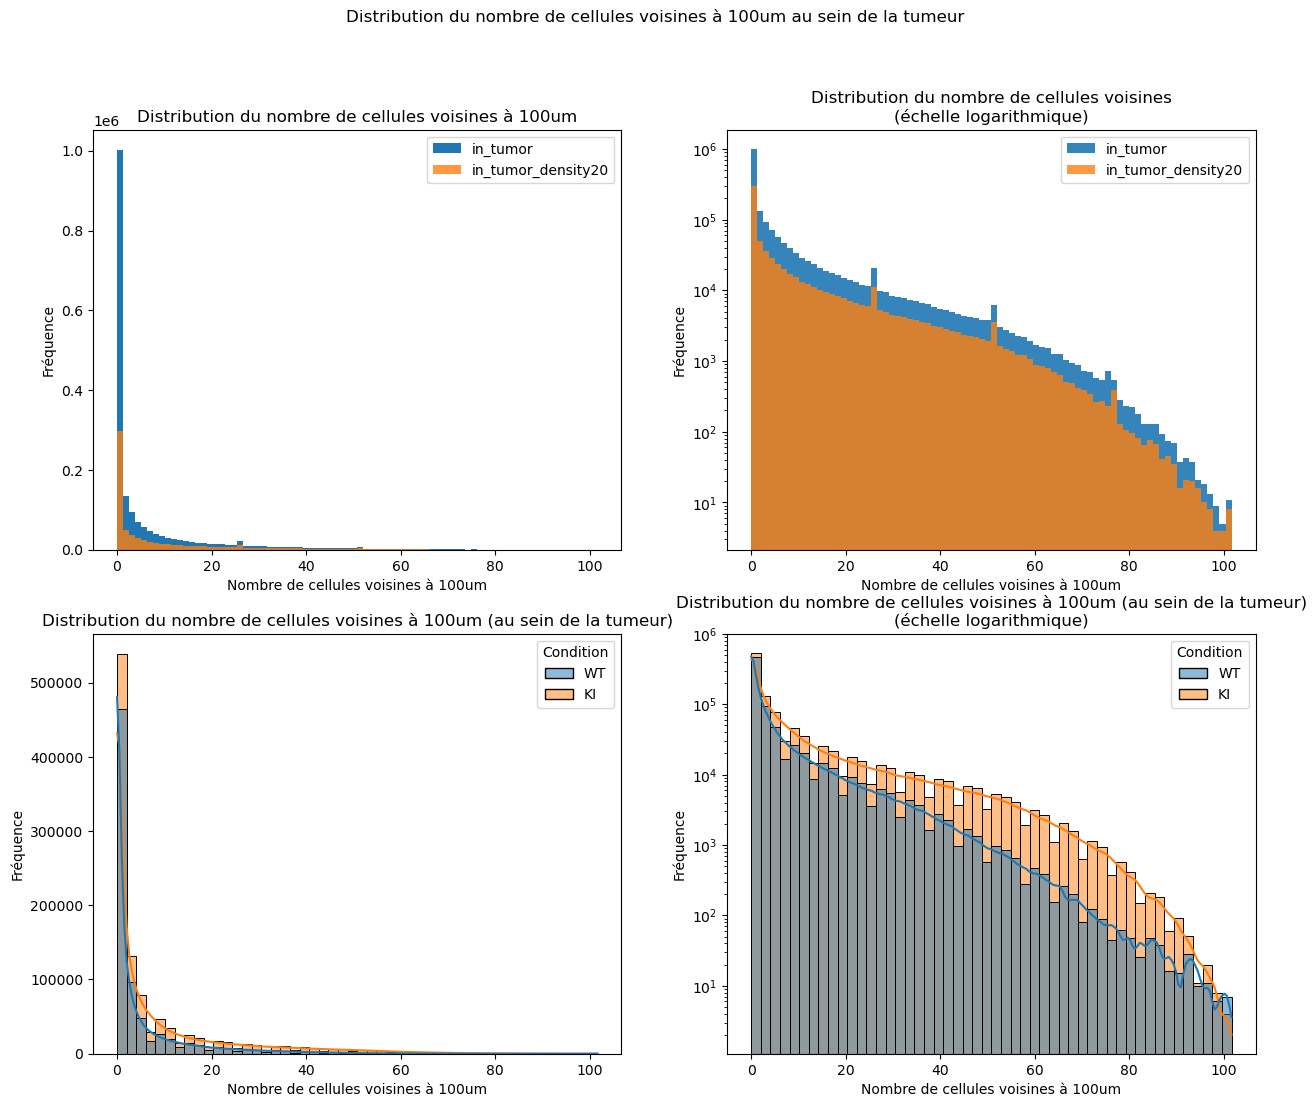

In [162]:
# Distribution du nombre de cellules voisines
#
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.hist(df_cd3_tumor["Cells100um"], bins=80, label="in_tumor")
ax1.hist(df_cd3_tumor[mask_density]["Cells100um"], bins=80, alpha=0.8, label="in_tumor_density20")
ax1.set_title("Distribution du nombre de cellules voisines à 100um")
ax1.set_xlabel("Nombre de cellules voisines à 100um")
ax1.set_ylabel("Fréquence")
ax1.legend()

ax2.hist(df_cd3_tumor["Cells100um"], bins=80, alpha=0.9, label="in_tumor")
ax2.hist(df_cd3_tumor[mask_density]["Cells100um"], bins=80, alpha=0.8, label="in_tumor_density20")
ax2.set_title("Distribution du nombre de cellules voisines\n(échelle logarithmique)")
ax2.set_xlabel("Nombre de cellules voisines à 100um")
ax2.set_ylabel("Fréquence")
ax2.set_yscale('log')
ax2.legend()

# wt & ki
sns.histplot(ax=ax3, data=df_cd3_tumor, hue="Condition", x="Cells100um", bins=50, kde=True)
#ax3.hist(df_cd3_tumor[mask_wt]["Cells100um"], bins=80, label="WT", color=)
#ax3.hist(df_cd3_tumor[mask_ki]["Cells100um"], bins=80, alpha=0.8, label="KI")
ax3.set_title("Distribution du nombre de cellules voisines à 100um (au sein de la tumeur)")
ax3.set_xlabel("Nombre de cellules voisines à 100um")
ax3.set_ylabel("Fréquence")

sns.histplot(ax=ax4, data=df_cd3_tumor, hue="Condition", x="Cells100um", bins=50, kde=True)
ax4.set_title("Distribution du nombre de cellules voisines à 100um (au sein de la tumeur)\n(échelle logarithmique)")
ax4.set_xlabel("Nombre de cellules voisines à 100um")
ax4.set_ylabel("Fréquence")
ax4.set_yscale('log')

plt.suptitle("Distribution du nombre de cellules voisines à 100um au sein de la tumeur\n")
plt.show()

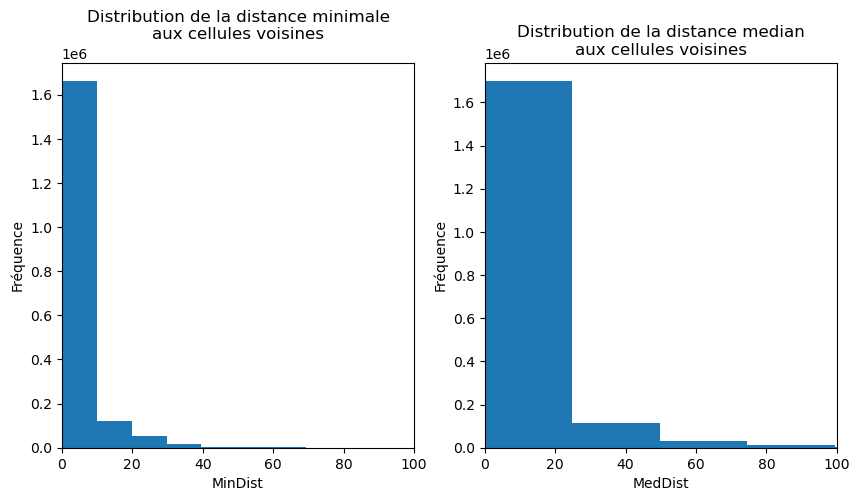

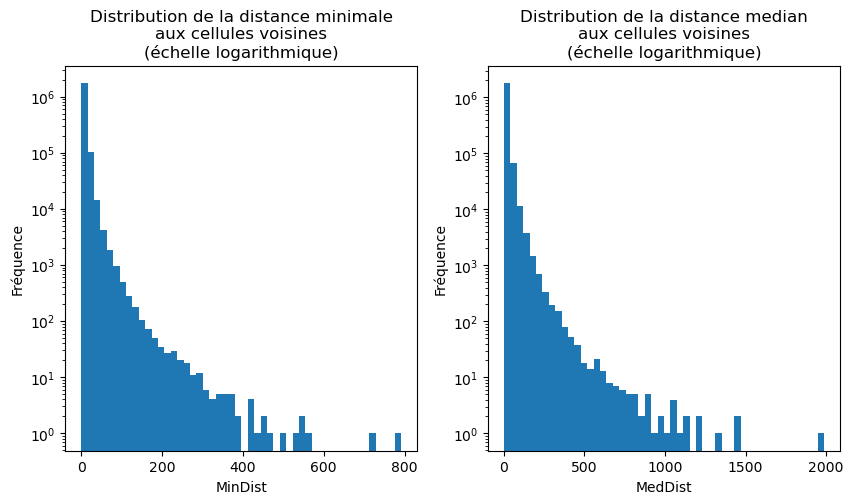

In [155]:
# Distance min & median aux cellules voisines
#
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df_cd3_tumor["MinDist"], bins=80)
ax1.set_title("Distribution de la distance minimale\naux cellules voisines")
ax1.set_xlabel("MinDist")
ax1.set_ylabel("Fréquence")
ax1.set_xlim((0, 100))

ax2.hist(df_cd3_tumor["MedDist"], bins=80)
ax2.set_title("Distribution de la distance median\naux cellules voisines")
ax2.set_xlabel("MedDist")
ax2.set_ylabel("Fréquence")
ax2.set_xlim((0, 100))
plt.show()

# Log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df_cd3_tumor["MinDist"], bins=50)
ax1.set_title("Distribution de la distance minimale\naux cellules voisines\n(échelle logarithmique)")
ax1.set_xlabel("MinDist")
ax1.set_ylabel("Fréquence")
ax1.set_yscale('log')

ax2.hist(df_cd3_tumor["MedDist"], bins=50)
ax2.set_title("Distribution de la distance median\naux cellules voisines\n(échelle logarithmique)")
ax2.set_xlabel("MedDist")
ax2.set_ylabel("Fréquence")
ax2.set_yscale('log')
plt.show()

# TODO : WT/CD64
# TODO: Réduire x_lim
# CityPlot, DensityPlot, Field2D, ScatterPlot Facs - Flow Cytometry - Seaborn

### Analyse supervisée

L'objectif consiste à déterminer le set de descripteur nous permettant de caractériser les zones enrichies en cellules T, ainsi que les zones T+

In [170]:
df_cd3_zones
x_columns = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns#, *shape_columns
    #*distances_columns, *cell_100um_columns
]
#x_columns.remove("Frac")
X = df_cd3_zones.dropna()[x_columns].values
Y = df_cd3_zones.dropna()["class_t_enriched"].values

X_train 

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
rf.fit(X, Y.ravel())

In [171]:
y_pred = rf.predict(X)
accuracy = accuracy_score(Y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6915070792617038


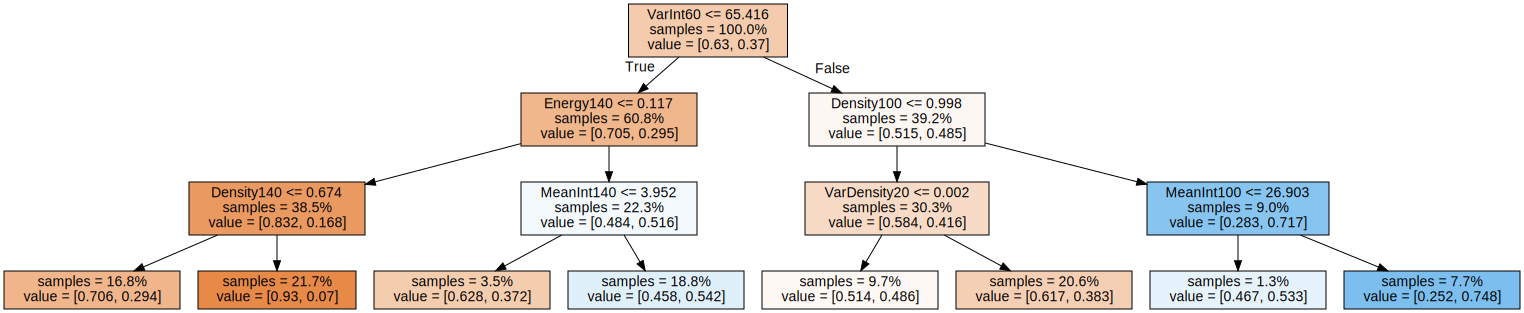

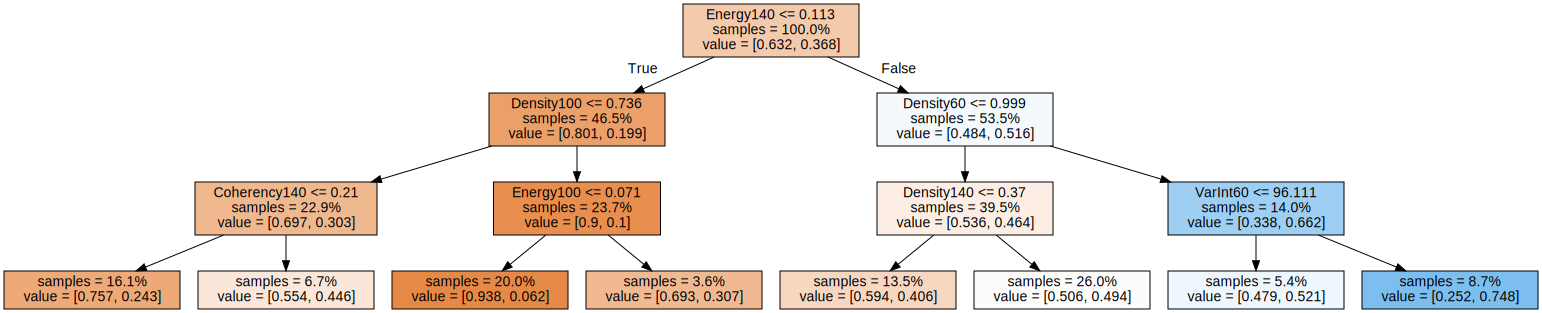

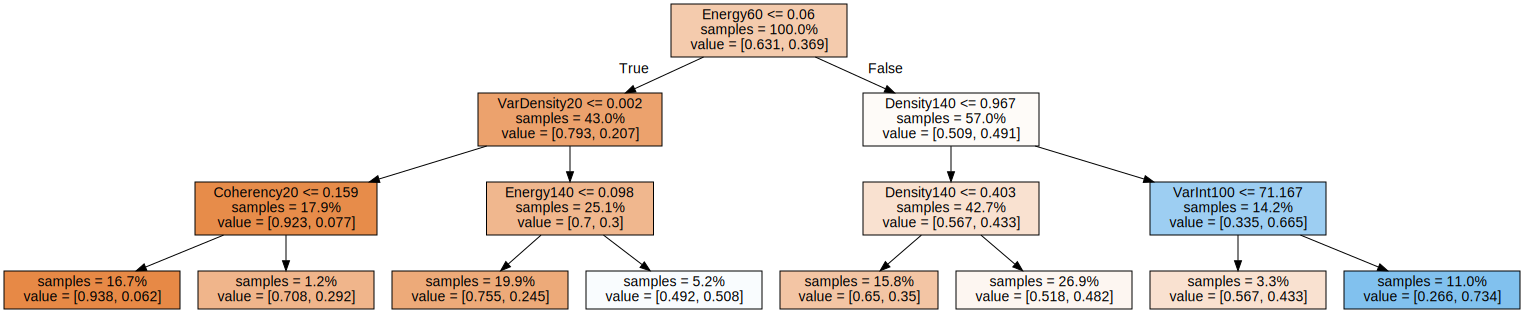

In [174]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_columns,  
                               filled=True,  
                               max_depth=4, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

# TODO : Classifier sur les fibres, 

In [ ]:
# With no_class
df_cd3_zones_b = df_cd3_zones[df_cd3_zones["class"] != "nothing"]
x_columns = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns, *cell_shape_columns,
    #*distances_columns, *cell_100um_columns
]
x_columns.remove("Frac")
X = df_cd3_zones_b.dropna()[x_columns].values
Y = df_cd3_zones_b.dropna()["class"].values

rf = RandomForestClassifier(n_estimators=3, random_state=42)
rf.fit(X, Y.ravel())

In [ ]:
y_pred = rf.predict(X)
accuracy = accuracy_score(Y, y_pred)
print("Accuracy:", accuracy)

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Nombre de Cellules T
### Analyse supervisée

In [ ]:
from sklearn.cross_decomposition import PLS

pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)
y_pred = rf.predict(X_test)

In [ ]:
plt.scatter(pls2.transform(X)[:, 0], Y)
plt.scatter(pls2.transform(X)[:, 0], pls2.predict(X))

In [ ]:


rf = RandomForestRegressor(n_estimators=3, random_state=42)
rf.fit(X, Y.ravel())

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

## Classification non hiérarchique des types de fibres

Nous nous intéressons à l'identification de classes permettant de caractériser la topologie des réseaux au sein de notre jeu de données.

In [ ]:
df_cd3_density = df_cd3_tumor[df_cd3_tumor["Density20"] > 0]
X = df_cd3_density.dropna()[x_columns].drop(columns=["Frac"]).values
Y = df_cd3_density.dropna()[y_columns].values

In [ ]:
f"{X.shape} {Y.shape}"

In [ ]:
x_columns

In [ ]:
df_cd3_density.isna().sum()

In [ ]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [ ]:
km = KMeans(n_clusters=4, n_init=50)
km.fit(X)
X_kmeans = km.transform(X)

In [ ]:
pca = PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=0.5)

In [ ]:
## Cell with density
i = 2
name = dt_cd3_tumor_perfile.index[i]
df_cd3_tumor_bis = df_cd3_tumor.copy()
fiber_class = km.predict(df_cd3_tumor_bis[x_columns].drop(columns=["Frac"]))
df_cd3_tumor_bis["class"] = fiber_class
# Show density
m = ExtractMap.ExtractMap(df_cd3_tumor_bis, "Density20", choose=name)
plt.imshow(m)
# Show T Cells
p = ExtractMap.ExtractMap(df_cd3_tumor_bis, "class", choose=name)
p[p == 0] = np.nan
plt.imshow(p, cmap=plt.cm.Reds)
plt.title(f"{dt_cd3_tumor_perfile['Name'].iloc[i]}\n{dt_cd3_tumor_perfile['Condition'].iloc[i]}")
plt.show()